In [6]:
import numpy as np
import pandas as pd
import copy

In [7]:
advised_pf = pd.read_pickle('./data/processed/advised_portfolios.pkl')

price_d = pd.read_pickle('./data/external/price_db_d.pkl')
price_d.date = price_d.date.astype(str)

pre_start_dt = '2019-02-27'
start_dt = '2019-02-28'
end_dt = '2021-2-26'
dates = pd.date_range(start_dt, end_dt)
dates = dates[dates.isin(price_d.date)]  # 거래일만
rebal_dates = pd.date_range(start_dt, end_dt, freq='M')

etf_info = pd.read_csv('./etf_info.csv', header=1)
df_etf = etf_info.loc[:, ['itemcode', 'itemname', 'risk_level']]

# 리밸런싱 주기(영업일)
rebal_freq = 20

from functools import partial
to_datetime_fmt = partial(pd.to_datetime, format='%Y-%m-%d')

In [18]:
df_etf

,itemcode,itemname,risk_level
0,A153130,KODEX 단기채권,1.0
1,A273130,KODEX 종합채권(AA-이상)액티브,2.0
2,A214980,KODEX 단기채권PLUS,1.0
3,A196230,KBSTAR 단기통안채,1.0
4,A114260,KODEX 국고채3년,1.0
5,A302190,TIGER 중장기국채,2.0
6,A130730,KOSEF 단기자금,1.0
7,A122260,KOSEF 통안채1년,1.0
8,A148070,KOSEF 국고채10년,2.0
9,A069500,KODEX 200,4.0


In [8]:
advised_pf.loc[(advised_pf.date==dates[0].strftime('%Y-%m-%d')) & (advised_pf.risk_profile==profile), ['date', 'itemcode', 'weights', 'itemname', 'price', 'asset_class']]

,date,itemcode,weights,itemname,price,asset_class
1014,2019-02-28,A251350,0.240,KODEX 선진국MSCI World,12800.0,Equity
1015,2019-02-28,A245340,0.240,TIGER 미국다우존스30,14233.0,Equity
1016,2019-02-28,A148070,0.240,KOSEF 국고채10년,116426.0,Fixed Income
1017,2019-02-28,A273130,0.140,KODEX 종합채권(AA-이상)액티브,104785.0,Fixed Income
1018,2019-02-28,A069500,0.112,KODEX 200,27566.0,Equity
1019,2019-02-28,A237370,0.020,KODEX 배당성장채권혼합,10626.0,Alternative
1020,2019-02-28,A266370,0.008,KODEX IT,11796.0,Equity


In [9]:
# def get_advised_port(dt, profile):
#     port[profile] = advised_pf.loc[
#         (advised_pf.date == dt) &
#         (advised_pf.risk_profile == profile),
#         ['date', 'itemcode', 'weights', 'itemname', 'price', 'asset_class']]
#     port[profile]['quantity'] = np.floor(inv_amt*port[profile].weights/port[profile].price)
#     port[profile]['value'] = port[profile]['price']*port[profile]['quantity']
#     cash = {
#         'date':dt,
#         'itemcode':'C000001',
#         'itemname':'Cash',
#         'price':1,
#         'asset_class':'Cash',
#         'quantity':inv_amt-port[profile]['value'].sum()
#     }
#     port[profile] = pd.concat((port[profile], pd.DataFrame().from_dict(cash, orient='index').T))
    
#     # 현금 포함해서 종목별 평가액과 비중 재계산
#     port[profile]['value'] = port[profile]['price']*port[profile]['quantity']
#     port[profile]['weights'] = port[profile]['value']/port[profile]['value'].sum()
#     port[profile].reset_index(drop=True, inplace=True)
#     port[profile]['date'] = dt.strftime('%Y-%m-%d')
#     port[profile] = pd.merge(port[profile],
#              price_d.loc[:, ['date', 'itemcode', 'ret']],
#              left_on=['date', 'itemcode'],
#              right_on=['date', 'itemcode'], how='left')
#     port[profile]['ret'] = port[profile]['ret'].fillna(0)
#     curr_port[profile] = port[profile].loc[port[profile].date==port[profile].date.max(), :]

#     return port[profile]

In [72]:
port = {}
curr_port = {}
inv_amt = 10e6

# 초기 포트폴리오 구성
dt = dates[0].strftime('%Y-%m-%d')
for profile in [2, 3, 4]:
#     curr_port[profile] = get_advised_port(dt, profile)
    port[profile] = advised_pf.loc[
        (advised_pf.date == dt) &
        (advised_pf.risk_profile == profile),
        ['date', 'itemcode', 'weights', 'itemname', 'price', 'asset_class']]
    port[profile]['quantity'] = np.floor(inv_amt*port[profile].weights/port[profile].price)
    port[profile]['value'] = port[profile]['price']*port[profile]['quantity']
    cash = {
        'date':dt,
        'itemcode':'C000001',
        'itemname':'Cash',
        'price':1,
        'asset_class':'Cash',
        'quantity':inv_amt-port[profile]['value'].sum()
    }
    port[profile] = pd.concat((port[profile], pd.DataFrame().from_dict(cash, orient='index').T))
    
    # 현금 포함해서 종목별 평가액과 비중 재계산
    port[profile]['value'] = port[profile]['price']*port[profile]['quantity']
    port[profile]['weights'] = port[profile]['value']/port[profile]['value'].sum()
    port[profile].reset_index(drop=True, inplace=True)
    port[profile]['date'] = dt
    port[profile] = pd.merge(port[profile],
             price_d.loc[:, ['date', 'itemcode', 'ret']],
             left_on=['date', 'itemcode'],
             right_on=['date', 'itemcode'], how='left')
    port[profile]['ret'] = port[profile]['ret'].fillna(0)
    port[profile]['original'] = 'Y'
    curr_port[profile] = port[profile].loc[port[profile].date==port[profile].date.max(), :]

# 매일 가격 업데이트 및 리밸런싱
for idx, dt in enumerate(dates[1:]):
    for profile in [2, 3, 4]:
        if (idx+1) % rebal_freq == 0:
            # 리밸런싱 주기 도래.
            # dt가 바로 리밸런싱일.
            next_dt = dt.strftime('%Y-%m-%d')
            
            # 자문 포트폴리오 가져오고
            next_port = advised_pf.loc[
                (advised_pf.date == next_dt) &
                (advised_pf.risk_profile == profile),
                ['date', 'itemcode', 'weights', 'itemname', 'price', 'asset_class']]
            inv_amt = curr_port[profile].value.sum()  # 직전까지의 최근 포트폴리오 nav
            next_port['quantity'] = np.floor(inv_amt*next_port.weights/next_port.price)
            next_port['value'] = next_port['price']*next_port['quantity']
            cash = {
                'date':next_dt,
                'itemcode':'C000001',
                'itemname':'Cash',
                'price':1,
                'asset_class':'Cash',
                'quantity':inv_amt-next_port['value'].sum()
            }
            next_port = pd.concat((next_port, pd.DataFrame().from_dict(cash, orient='index').T))
            # 현금 포함해서 종목별 평가액과 비중 재계산
            next_port['value'] = next_port['price']*next_port['quantity']
            next_port['weights'] = next_port['value']/next_port['value'].sum()
            next_port.reset_index(drop=True, inplace=True)
            next_port['date'] = next_dt
            next_port = pd.merge(next_port,
                     price_d.loc[price_d.date==dt, ['date', 'itemcode', 'ret']],
                     left_on=['date', 'itemcode'],
                     right_on=['date', 'itemcode'], how='left')
            next_port['ret'] = next_port['ret'].fillna(0)
            next_port['original'] = 'Rebal'
            port[profile] = pd.concat((port[profile], next_port))
            curr_port[profile] = next_port
        else:
            # 가격 업데이트
            next_port = copy.deepcopy(curr_port[profile])
            next_dt = dt.strftime('%Y-%m-%d')
            next_port['date'] = next_dt
            next_port = pd.merge(next_port,
                                 price_d.loc[price_d.date == next_dt,
                                             ['date', 'itemcode', 'price', 'ret']],
                                 left_on=['date', 'itemcode'],
                                 right_on=['date', 'itemcode'],
                                 suffixes=('_cur', '_next'),
                                 how='left')
            next_port.drop(['price_cur', 'ret_cur'], axis=1, inplace=True)
            next_port.rename({'price_next':'price', 'ret_next':'ret'}, axis=1, inplace=True)
            next_port.price = next_port.price.fillna(1)
            next_port.ret = next_port.ret.fillna(0)

            # 종목별 평가액과 비중 업데이트
            next_port['value'] = next_port['price']*next_port['quantity']
            next_port['weights'] = next_port['value']/next_port['value'].sum()
            port[profile] = pd.concat((port[profile], next_port))
            next_port['original'] = 'N'
            curr_port[profile] = next_port  # 업데이트된 최근 포트폴리오를 curr_port에 저장

### 리밸런싱일

In [81]:
for idx, dt in enumerate(dates[1:]):
    if (idx+1) % rebal_freq == 0:
        print(dt)

2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-28 00:00:00
2019-06-26 00:00:00
2019-07-24 00:00:00
2019-08-22 00:00:00
2019-09-23 00:00:00
2019-10-23 00:00:00
2019-11-20 00:00:00
2019-12-18 00:00:00
2020-01-20 00:00:00
2020-02-19 00:00:00
2020-03-18 00:00:00
2020-04-16 00:00:00
2020-05-19 00:00:00
2020-06-16 00:00:00
2020-07-14 00:00:00
2020-08-11 00:00:00
2020-09-09 00:00:00
2020-10-13 00:00:00
2020-11-10 00:00:00
2020-12-08 00:00:00
2021-01-08 00:00:00
2021-02-05 00:00:00


In [73]:
temp = pd.DataFrame(columns=port[2].columns)
temp['risk_profile'] = 2

In [74]:
for profile in [2,3,4]:
    port[profile] = port[profile].merge(df_etf.loc[:, ['itemcode', 'risk_level']], left_on='itemcode', right_on='itemcode', how='left')
    port[profile]['risk_level'].fillna(0, inplace=True)
    port[profile]['risk_profile'] = profile
    temp = pd.concat((temp, port[profile]))
    

In [75]:
temp

,date,itemcode,weights,itemname,price,asset_class,quantity,value,ret,original,risk_profile,risk_level
0,2019-02-28,A196230,0.23388,KBSTAR 단기통안채,101687,Fixed Income,23,2.3388e+06,0.000000,Y,2,1.0
1,2019-02-28,A214980,0.230782,KODEX 단기채권PLUS,100340,Fixed Income,23,2.30782e+06,0.000100,Y,2,1.0
2,2019-02-28,A148070,0.162996,KOSEF 국고채10년,116426,Fixed Income,14,1.62996e+06,0.000490,Y,2,2.0
3,2019-02-28,A273130,0.125742,KODEX 종합채권(AA-이상)액티브,104785,Fixed Income,12,1.25742e+06,0.000668,Y,2,2.0
4,2019-02-28,A114260,0.0949025,KODEX 국고채3년,55825,Fixed Income,17,949025,0.000269,Y,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3713,2021-02-26,A157490,0.243915,TIGER 소프트웨어,16725,Equity,179,2.99378e+06,-0.017485,N,4,5.0
3714,2021-02-26,A266370,0.133005,KODEX IT,21480,Equity,76,1.63248e+06,-0.035220,N,4,5.0
3715,2021-02-26,A278540,0.0818203,KODEX MSCI Korea TR,13390,Equity,75,1.00425e+06,-0.029798,N,4,4.0
3716,2021-02-26,A148070,0.0589888,KOSEF 국고채10년,120670,Fixed Income,6,724020,-0.007060,N,4,2.0


In [78]:
temp.to_excel('port_backtesting_results.xls')

In [53]:
port[2].loc[:, ['date', 'itemname', 'weights', '']].pivot_table(
               index='date',
               columns=['itemname'],
               values='weights')

DataError: No numeric types to aggregate

In [51]:
pd.melt(port[2].loc[:, ['date', 'itemname', 'weights']],
        id_vars='date', value_vars='weights', value_name='itemname')

C:\ProgramData\Anaconda3\envs\ra\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,variable,itemname
0,2019-02-28,weights,0.23388
1,2019-02-28,weights,0.230782
2,2019-02-28,weights,0.162996
3,2019-02-28,weights,0.125742
4,2019-02-28,weights,0.0949025
...,...,...,...
4347,2021-02-26,weights,0.111294
4348,2021-02-26,weights,0.0961613
4349,2021-02-26,weights,0.0769715
4350,2021-02-26,weights,0.0194734


<AxesSubplot:xlabel='date'>

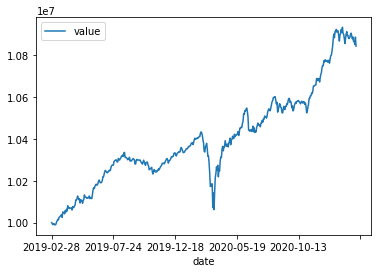

In [11]:
port[2].loc[:, ['date', 'value']].groupby('date').sum().plot()